<h2>1. Import</h2>

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator


<h2>2. Loading Data</h2>


In [4]:
#label
labels = os.listdir('data/train')
labels

['Closed', 'no_yawn', 'Open', 'yawn']

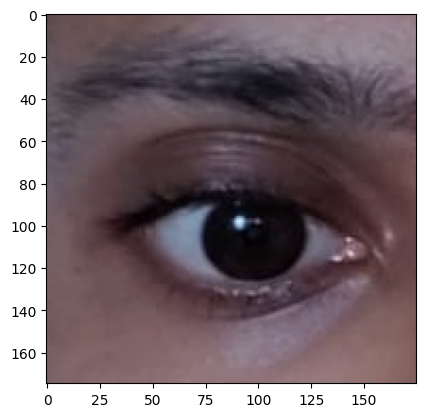

In [6]:
#Visualize a random image
img = plt.imread('data/train/Open/_0.jpg')
plt.imshow(img)

In [7]:
#img shape
img.shape

(175, 175, 3)

<h2>3. Reprocessing Data</h2>


take face for yawn and not_yawn

In [8]:
def face_for_yawn(direc='data/train/', face_cascade_path='require_file/haarcascade_frontalface_default.xml'):
    yawn_no = []
    img_size = 145
    categories = ['yawn','no_yawn']
    for category in categories:
        path_link = os.path.join(direc, category)
        num = categories.index(category) 
        print(num) #0: yawn, 1:no_yawn
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cascade_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x,y,w,h) in faces: #take only face
                img = cv2.rectangle(image_array, (x,y), (x+w,y+h), (0,255,0), 2)
                roi_color = img[y:y+h,x:x+w]
                resized_array = cv2.resize(roi_color, (img_size,img_size))
                yawn_no.append([resized_array,num])
    
    return yawn_no

In [9]:
yawn_no_yawn = face_for_yawn()

0
1


take face for closed eye and opened eyes 

In [33]:
def take_for_eyes(direc='data/train', face_cascade_path='require_file/haarcascade_frontalface_default.xml', eye_cascade_path='require_file/haarcascade.xml'):
    eye_no = []
    img_size = 145
    categories = ['Closed', 'Open']
    for category in categories:
        path_link = os.path.join(direc, category)
        num = categories.index(category)
        num = num + 2 #from 2, 2: closed, 3:open
        print(num)
        for img in os.listdir(path_link):
            try:
                img_array = cv2.imread(os.path.join(path_link,img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (img_size,img_size))
                eye_no.append([resized_array,num])
            except Exception as e:
                print(e)
    
    return eye_no

In [34]:
eye_no_eye = take_for_eyes()

2
3


Extend data and convert to array

In [35]:
def append_data():
    yawn_no = face_for_yawn()
    eye_no = take_for_eyes()
    yawn_no.extend(eye_no) #add eye_no to the end yawn_no
    return np.array(yawn_no,dtype="object")

In [36]:
new_data = append_data()

0
1
2
3


Separate label and features

In [37]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [46]:
len(X)

1925

In [47]:
len(y)

1925

reshape the array

In [48]:
X = np.array(X)
X = X.reshape(-1,145,145,3) #(num_feature, img size, img size, RGB)

Label Binarizer

In [49]:
label_bin = preprocessing.LabelBinarizer()
y = label_bin.fit_transform(y)

In [50]:
y = np.array(y)

### Train Test Split

In [51]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed,test_size=test_size)

In [52]:
len(X_test)

578

### Data Agumentation

In [53]:
train_generator = ImageDataGenerator(rescale=1/255.0, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train),y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test),y_test, shuffle=False)

<h2>4. Building Model</h2>

In [54]:
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', input_shape=(145,145,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [58]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

<h2>5. Training Model</h2>


In [60]:
history = model.fit(train_generator, validation_data=test_generator, epochs=50, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 206s 5s/step - loss: 1.1609 - accuracy: 0.4714 - val_loss: 0.5285 - val_accuracy: 0.7941
Epoch 2/50
43/43 [==============================] - 193s 4s/step - loss: 0.5233 - accuracy: 0.7877 - val_loss: 0.4190 - val_accuracy: 0.7872
Epoch 3/50
43/43 [==============================] - 218s 5s/step - loss: 0.4207 - accuracy: 0.8233 - val_loss: 0.4359 - val_accuracy: 0.8131
Epoch 4/50
43/43 [==============================] - 222s 5s/step - loss: 0.3371 - accuracy: 0.8634 - val_loss: 0.2656 - val_accuracy: 0.8927
Epoch 5/50
43/43 [==============================] - 206s 5s/step - loss: 0.2696 - accuracy: 0.8901 - val_loss: 0.3213 - val_accuracy: 0.8599
Epoch 6/50
43/43 [==============================] - 211s 5s/step - loss: 0.2821 - accuracy: 0.8820 - val_loss: 0.2189 - val_accuracy: 0.9066
Epoch 7/50
43/43 [==============================] - 210s 5s/step - loss: 0.2656 - accuracy: 0.8886 - val_loss: 0.1857 - val_accuracy: 0.9135
Epoch 8/50
43

In [61]:
model.save("drowsiness_detection.h5")

c:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
model.save("drowsiness_detection.model")

INFO:tensorflow:Assets written to: drowsiness_detection.model\assets


INFO:tensorflow:Assets written to: drowsiness_detection.model\assets


<h2>6. Evaluating Model - Acuracy</h2>


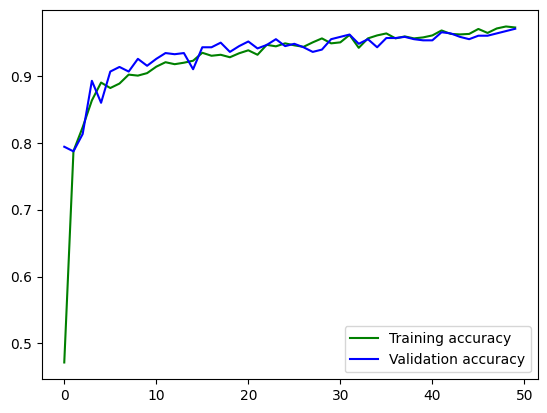

In [91]:
accuracy = history.history['accuracy'] #training accuracy
val_accuracy = history.history['val_accuracy'] #validation accuracy
loss = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, color='g', label='Training accuracy')
plt.plot(epochs, val_accuracy, color='b', label='Validation accuracy')
plt.legend()
plt.show()

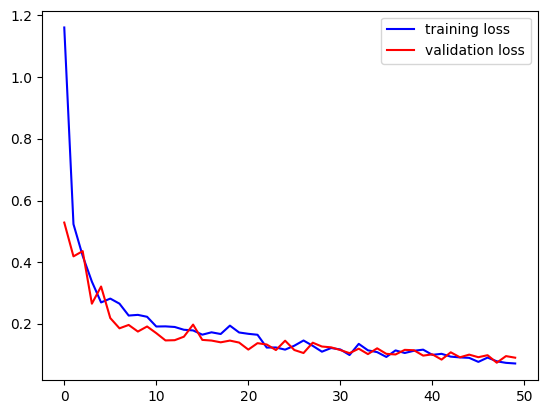

In [92]:
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

<h2>7. Prediction</h2>


### 0:Yawn, 1:no_yawn, 2:closed, 3:open

In [140]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
img_size = 145
def prepare(filepath, face_cas="require_file/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255.0
    resized_array = cv2.resize(img_array, (img_size, img_size))
    return resized_array.reshape(-1, img_size, img_size, 3)

model = tf.keras.models.load_model("drowsiness_detection.h5")

In [174]:
def prediction_check(prediction):
    if prediction == 0:
        print('0')
    elif prediction == 1:
        print('1')
    elif prediction == 2:
        print('Closed eyes')
    elif prediction == 3:
        print('Open eyes')
        

1/1 [==============================] - 0s 51ms/step
Open eyes


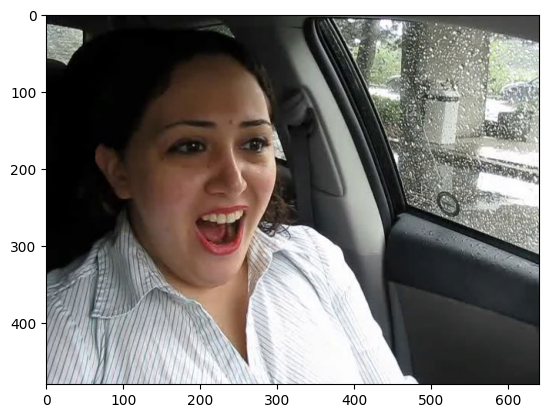

In [178]:
plt.imshow(plt.imread("data/train/yawn/103.jpg"))
prediction = model.predict([prepare("data/train/yawn/103.jpg")])
prediction_check(np.argmax(prediction))

### Take another image 

1/1 [==============================] - 0s 80ms/step
Open eyes


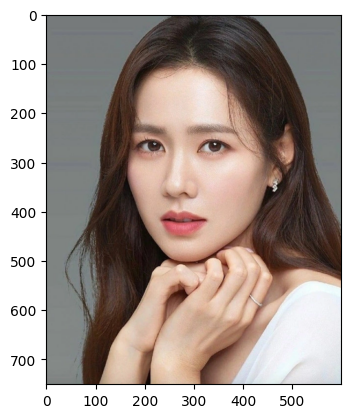

In [162]:
plt.imshow(plt.imread("check/son-ye-jin-1-open.webp"))
prediction = model.predict([prepare("check/son-ye-jin-1-open.webp")])
prediction_check(np.argmax(prediction))

1/1 [==============================] - 0s 54ms/step
Closed eyes


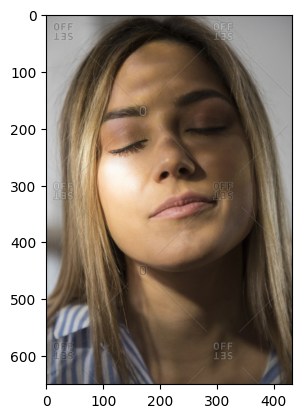

In [171]:
plt.imshow(plt.imread("check/closed4.jpg"))
prediction = model.predict([prepare("check/closed4.jpg")])
prediction_check(np.argmax(prediction))